In [1]:
from tvDatafeed import TvDatafeed,Interval
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
import json
import numpy as np
import requests
from trade import cross_ema, ichimoku_cloud, macd
# from talib.abstract import EMA, MACD

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
tv = TvDatafeed(username=None,password=None)

you are using nologin method, data you access may be limited


In [112]:
nifty_data=tv.get_hist('TENCENT80','SET',interval=Interval.in_daily,n_bars=10000)

In [3]:
with open(os.path.join(os.getcwd(),'config','list_stock','stock_config.json')) as f:
    json_stock = json.load(f)

In [4]:
def get_data(tv, exchange, name_stock, n_bars):
    return tv.get_hist(name_stock, exchange, interval=Interval.in_daily, n_bars=n_bars)

4571   2022-12-08 09:00:00
Name: datetime, dtype: datetime64[ns]

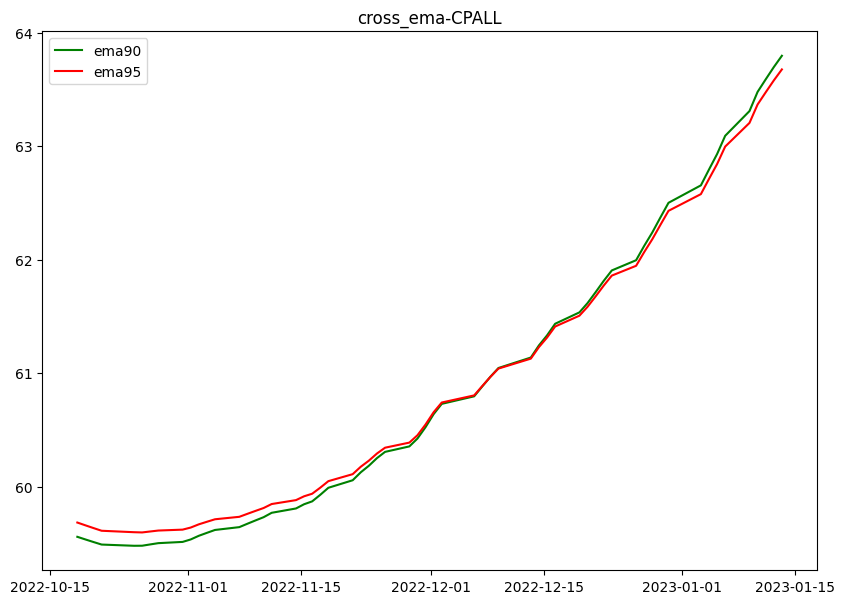

In [54]:
indicator_config = {
    "cross_ema":{
        "low_span": 90,
        "long_span": 95
    },
    "plot_config":{
        "plot": True,
        "n_bar": 60
    }
}

# def calc_sum(df):
#     print(df)
    # if df['low_df'] is not np.nan and df['long_df'] is not np.nan:
    # if df['low_df'] > df['long_df']:
    #     return 0
    # return 1
    
# หาวันที่ควรซื้อหุ้นนี้ล่าสุด
df = get_data(tv, "SET", "CPALL", 10000)
result, df = cross_ema(df,"CPALL",**indicator_config)
df = df.reset_index()
df = df.dropna()
df = df.reset_index()
df['bors'] = df['low_df'] - df['long_df']
index_value = df[df['bors'] < 0].iloc[-1:].index.values[0]
df_date_buy = df.iloc[[int(index_value)+1]]
df_date_buy['datetime']
# df['bors'] = df.apply(calc_sum)

# df[df['ema']==0].iloc[-1:]

In [68]:
import datetime

In [69]:
df_date_buy['datetime'].values[0]

numpy.datetime64('2022-12-08T09:00:00.000000000')

In [70]:
# convert from numpy.datetime64 to datetime.datetime
unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
seconds_since_epoch = (df_date_buy['datetime'].values[0] - unix_epoch) / one_second
d = datetime.datetime.utcfromtimestamp(seconds_since_epoch)
d

datetime.datetime(2022, 12, 8, 9, 0)

In [77]:
cc = datetime.datetime.today().date() - d.date()
print(cc.days)

38


In [8]:
from talib.abstract import EMA, MACD

In [9]:
def macd_test(df, namest):
    df['macd_line'], df["signal_line"], _ = MACD(df['close'])
    macd_line = list(df['macd_line'])
    signal_line = list(df["signal_line"])
        
    #     buy
    if macd_line[-1] > signal_line[-1]:
        return 2, df #False
    #     sell
    elif macd_line[-1] < signal_line[-1]:
        return -1, df #True
    return 0, df

In [19]:
v = {'a':12,'b':20,'c':2}
dict(sorted(v.items(), key=lambda item: item[1],reverse=True))


{'b': 20, 'a': 12, 'c': 2}

In [20]:
r= {}
r['a']=1
r['b']=12
r

{'a': 1, 'b': 12}

In [11]:
df = get_data(tv, "SET", "CPALL", 100)
df = df.reset_index()
df = df[df['close'] == min(list(df['close']))] 
df
# df = df.iloc[:,2:]

# c= macd_test(df=df, namest="CPALL")
# ichimoku_cloud(df = df, namest="CPALL")
# macd(df = df, namest="CPALL")
# low_df = EMA(df['close'], 90)
# print(low_df[-1])
# low_df
# long_df = EMA(df['close'], long_span)

,datetime,symbol,open,high,low,close,volume
32,2022-10-07 09:00:00,SET:CPALL,54.5,54.5,53.5,53.75,11873659.0


In [13]:
c[0]

-1

In [15]:
list(df['macd_line'])[-1]

1.013803161925182

In [43]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

list_stock = list()
indicator_config = {
    "cross_ema":{
        "low_span": 90,
        "long_span": 95
    }
}

config = {
    "find-min": True,
    "find-max": True
}

# loop key score
dict_stock_name_score = {}
dict_min_value_1 = {}
dict_min_value_2 = {}

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        dict_stock_name_score.update({namest:0})

print('dict_stock_name_score:',dict_stock_name_score)

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        data = get_data(tv, key_exc, namest, 3000)
        data = data.reset_index()
        
        result_ema = cross_ema(df = data, namest = namest, **indicator_config)
        result_ichimoku = ichimoku_cloud(df = data, namest = namest)
        result_macd = macd(df = data, namest= namest)

        dict_stock_name_score[namest] = dict_stock_name_score[namest] + result_ema[0] + result_ichimoku[0] + result_macd[0]

        # find min
        list_time = [62, 93]
        for t in list_time:
            data_follow_time = get_data(tv, key_exc, namest, t)
            data_follow_time = data_follow_time.reset_index()
            df_min_value = data_follow_time[data_follow_time['close'] == min(list(data_follow_time['close']))]
            df_current_value = data_follow_time.iloc[-2:-1,:]
            if t == 62:
                dict_min_value_1[namest] = abs(df_current_value['close'].values[0] - min(list(data_follow_time['close'])))
            else:
                dict_min_value_2[namest] = abs(df_current_value['close'].values[0] - min(list(data_follow_time['close'])))
    #     break
    # break

dict_min_value_1_sort = dict(sorted(dict_min_value_1.items(), key=lambda item: item[1]))
dict_min_value_2_sort = dict(sorted(dict_min_value_2.items(), key=lambda item: item[1]))

print('-'*100)
print('result:',dict_stock_name_score)
print('-'*100)
print('dict_min_value_1:',dict_min_value_1)
print('-'*100)
print('dict_min_value_2:',dict_min_value_2)
print('-'*100)
print('dict_min_value_1_sort:',dict_min_value_1_sort)
print('-'*100)
print('dict_min_value_2_sort:',dict_min_value_2_sort)
print('-'*100)

# dict_min_value_sort = dict(sorted(dict_min_value_2.items(), key=lambda item: item[1],reverse=True))

    # for namest, nbar in json_stock[exc].items():
    #     data = get_data(tv, exc, namest, nbar['limit_data'])

    #     # ทำหลายๆ cross ema โดยใช้ distance 5 and 100 ในการตัดสินใจ
    #     result_ema = cross_ema(data, namest, **indicator_config)
        
    #     print()
    #     print('name stock:',namest)

    #     # find min close value
    #     # number of days -> 62:1 row/month, 93:2 row/month
    #     list_time = [62, 93]
    #     for t in list_time:
    #         print(f'exc:{exc}, namest:{namest}, t:{t}')
    #         data_follow_time = get_data(tv, exc, namest, t)
    #         min_data = data_follow_time[data_follow_time['close'] == data_follow_time['close'].min()]
    #         min_data = min_data.reset_index()
    #         print(f"min data --> date: {min_data['datetime'].values[0]}, close: {min_data['close'].values[0]}")
    #         break
    #         # print current price of stock

    #         # 1 เดือนลบกับปัจจุบันและ 2 เดือนลบกับปัจจุบัน

    #         # 

    #     if result_ema == 1:
    #         print('sell')
    #     elif result_ema == 0:
    #         print('buy')
    #     else:
    #         print('noting')
    #     print()


dict_stock_name_score: {'M': 0, 'CRC': 0, 'HMPRO': 0, 'TISCO': 0, 'CPALL': 0, 'KBANK': 0, 'DELTA': 0, 'AOT': 0, 'BANPU': 0, 'BDMS': 0, 'ADVANC': 0, 'PTTEP': 0, 'PTT': 0, 'COM7': 0, 'TOP': 0, 'SCB': 0, 'THG': 0, 'AAPL': 0}
test: 57.369175013239285
test: 42.48296654151405
test: 14.690054234856898
test: 97.29341663985963
test: 64.08971238192967
test: 147.5476979333275
test: 681.2158876724807
test: 73.4819556689016
test: 12.969512128892848
test: 28.99957459151064
test: 194.01460418295807
test: 172.6526718649349
test: 33.87470185273245
test: 32.737782522228486
test: 54.73952002201208
test: 107.00531939384939
test: 67.16914128447361
test: 141.97239698373963
----------------------------------------------------------------------------------------------------
result: {'M': 0, 'CRC': 3, 'HMPRO': 3, 'TISCO': 6, 'CPALL': 3, 'KBANK': 4, 'DELTA': 3, 'AOT': 3, 'BANPU': 1, 'BDMS': 4, 'ADVANC': 1, 'PTTEP': 4, 'PTT': 1, 'COM7': 0, 'TOP': 6, 'SCB': 1, 'THG': 3, 'AAPL': 0}
--------------------------------

In [36]:
abs(1-10)

9

In [41]:
data_follow_time.iloc[-2:-1,:]['close'].values[0]

135.94

In [20]:
data = data.reset_index()
data


,datetime,symbol,open,high,low,close,volume,low_df,long_df
0,2019-01-30 21:30:00,NASDAQ:AAPL,40.8125,41.53750,40.057500,41.3125,244439120.0,NaN,NaN
1,2019-01-31 21:30:00,NASDAQ:AAPL,41.5275,42.25000,41.140000,41.6100,162958596.0,NaN,NaN
2,2019-02-01 21:30:00,NASDAQ:AAPL,41.7400,42.24500,41.482500,41.6300,130672552.0,NaN,NaN
3,2019-02-04 21:30:00,NASDAQ:AAPL,41.8525,42.91375,41.820000,42.8125,125982328.0,NaN,NaN
4,2019-02-05 21:30:00,NASDAQ:AAPL,43.2150,43.77000,43.087525,43.5450,144406512.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,2023-01-11 21:30:00,NASDAQ:AAPL,131.2500,133.51000,130.460000,133.4900,69458949.0,142.620758,143.025301
996,2023-01-12 21:30:00,NASDAQ:AAPL,133.8800,134.26000,131.440000,133.4100,71379648.0,142.418324,142.824983
997,2023-01-13 21:30:00,NASDAQ:AAPL,132.0300,134.92000,131.660000,134.7600,57809719.0,142.250009,142.656962
998,2023-01-17 21:30:00,NASDAQ:AAPL,134.8300,137.29000,134.130000,135.9400,63646627.0,142.111327,142.517025


In [67]:
print(min_data['datetime'].values[0])

2020-03-24T09:00:00.000000000


In [40]:
q = mp.Queue()
list_rstock = list()
for value in loop_yield(list_stock):
    for v in value:
        k,l = v
        print(get_data(tv, 'SET', k, l))
        # p = mp.Process(target=get_data, args=(tv, 'SET', k, l, q))
        # p.start()
        # print(k,l)
        # list_rstock.append(q.get())
        break
    break

                    symbol   open   high    low  close       volume
datetime                                                           
2013-08-15 09:00:00  SET:M  54.50  55.50  52.50  53.00  131190700.0
2013-08-16 09:00:00  SET:M  52.50  54.00  52.50  52.75   26475300.0
2013-08-19 09:00:00  SET:M  52.75  52.75  49.50  49.50   25885000.0
2013-08-20 09:00:00  SET:M  48.75  50.25  48.75  50.00   14450600.0
2013-08-21 09:00:00  SET:M  49.75  50.25  48.50  48.50   12034400.0
...                    ...    ...    ...    ...    ...          ...
2022-11-07 09:00:00  SET:M  57.75  58.50  57.75  58.25     331139.0
2022-11-08 09:00:00  SET:M  58.25  58.50  57.75  58.00     262818.0
2022-11-09 09:00:00  SET:M  58.00  58.25  56.75  57.25     708665.0
2022-11-10 09:00:00  SET:M  57.00  57.75  56.75  57.25     269112.0
2022-11-11 09:00:00  SET:M  57.25  58.00  55.25  57.25    2767386.0

[2250 rows x 6 columns]


In [16]:
stock_list = tv.search_symbol('M',exchange='SET')

In [22]:
tv.get_hist('M','SET',interval=Interval.in_daily,n_bars=10000)

,symbol,open,high,low,close,volume
datetime,,,,,,
2013-08-15 09:00:00,SET:M,54.50,55.50,52.50,53.00,131190700.0
2013-08-16 09:00:00,SET:M,52.50,54.00,52.50,52.75,26475300.0
2013-08-19 09:00:00,SET:M,52.75,52.75,49.50,49.50,25885000.0
2013-08-20 09:00:00,SET:M,48.75,50.25,48.75,50.00,14450600.0
2013-08-21 09:00:00,SET:M,49.75,50.25,48.50,48.50,12034400.0
...,...,...,...,...,...,...
2022-11-01 09:00:00,SET:M,58.50,58.50,57.50,57.75,530824.0
2022-11-02 09:00:00,SET:M,57.75,58.50,57.50,58.50,330307.0
2022-11-03 09:00:00,SET:M,58.50,58.75,58.00,58.75,395868.0


In [3]:
import pyttsx3

def generate_speech(text):
  engine = pyttsx3.init()
  engine.say(text)
  engine.runAndWait()

ModuleNotFoundError: No module named 'pyttsx3'

In [18]:
from datetime import datetime

In [19]:
datetime.now().strftime('%Y%m%d')

'20230117'

In [10]:
from utils import read_config
config_plot = read_config(os.path.join(os.getcwd(),'config','plot_image','plot_config.json'))
config_plot

{'plot_config': {'plot': False, 'n_bar': 60}}

In [11]:
config_plot['plot_config']

{'plot': False, 'n_bar': 60}